In this tutorial, you will learn the basic workflow of PyGOD with an example of DOMINANT. This tutorial assumes that you have basic familiarity with PyTorch and PyTorch Geometric (PyG).

PyGOD use torch_geometric.data.Data to handle the data. Here, we use Cora, a PyG built-in dataset, as an example. To load your own dataset into PyGOD, you can refer to creating your own datasets tutorial in PyG.

In [1]:
import torch
import pandas as pd
from pygod.metric import eval_roc_auc
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from pygod.generator import gen_contextual_outlier, gen_structural_outlier

ModuleNotFoundError: No module named 'pygod'

In [ ]:
data = Planetoid('./data/Cora', 'Cora', transform=T.NormalizeFeatures())[0]

Because there is no ground truth label of outliers in Cora, we follow the method used by DOMINANT to inject 100 contextual outliers and 100 structure outliers into the graph. Note: If your dataset already contains the outliers you want to detect, you don’t have to inject more outliers.

In [ ]:

data, ya = gen_contextual_outlier(data, n=100, k=10)
data, ys = gen_structural_outlier(data, m=10, n=10)

data.y = torch.logical_or(ys, ya).long()


In [ ]:
#contamos cuantas etiquetas tiene data.y
print(data.y.unique(return_counts=True))


(tensor([0, 1]), tensor([2510,  198]))


We also provide various type of built-in datasets. You can load them by passing the name of the dataset to load_data function. See data repository for more details.

In [ ]:
from pygod.utils import load_data

data = load_data('inj_cora')
data.y = data.y.bool()

You can use any detector by simply initializing without passing any arguments. Default hyperparameters are ready for you. Of course, you can also customize the parameters by passing arguments. Here, we use pygod.detector.DOMINANT as an example.

In [ ]:
from pygod.detector import DOMINANT

detector = DOMINANT(hid_dim=64, num_layers=6, epoch=100)

To train the detector with the loaded data, simply feed the torch_geometric.data.Data object into the detector via fit.

In [ ]:
detector.fit(data)

DOMINANT(act=<function relu at 0x0000020082B5F430>,
         backbone=<class 'torch_geometric.nn.models.basic_gnn.GCN'>,
         batch_size=2708, compile_model=False, contamination=0.1,
         dropout=0.0, epoch=100, gpu=None, hid_dim=64, lr=0.004,
         num_layers=6, num_neigh=[-1, -1, -1, -1, -1, -1], save_emb=False,
         sigmoid_s=False, verbose=0, weight=0.5, weight_decay=0.0)

After training, the detector is ready to use. You can use the detector to predict the labels, raw outlier scores, probability of the outlierness, and prediction confidence. Here, we use the loaded data as an example.

In [ ]:
pred, score, prob, conf = detector.predict(data,
                                           return_pred=True,
                                           return_score=True,
                                           return_prob=True,
                                           return_conf=True)
print('Labels:')
print(pred)

print('Raw scores:')
print(score)

print('Probability:')
print(prob)

print('Confidence:')
print(conf)

#contruir el dataframe con todos los campos anteriores:

df = pd.DataFrame({'pred': pred, 'score': score, 'prob': prob, 'conf': conf})



Labels:
tensor([0, 0, 0,  ..., 0, 0, 0])
Raw scores:
tensor([1.0294, 0.9658, 1.2197,  ..., 0.6144, 1.1305, 1.1338])
Probability:
tensor([0.0886, 0.0763, 0.1256,  ..., 0.0080, 0.1083, 0.1089])
Confidence:
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [ ]:
# transformar las predicciones a etiquetas binarias booleanas
#  UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).pred = torch.tensor(pred).bool()
# crear copia de la variable para luego obtener la matriz de confusión comparando valores booleanos

predichos = torch.tensor(pred).bool()
print(predichos.unique(return_counts=True))

C:\Users\Carlo\AppData\Local\Temp\ipykernel_1488\3405754976.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predichos = torch.tensor(pred).bool()


(tensor([False,  True]), tensor([2437,  271]))


To evaluate the performance outlier detector with AUC score, you can:

In [ ]:
auc_score = eval_roc_auc(data.y, score)
print('AUC Score:', auc_score)

AUC Score: 0.765834884114363


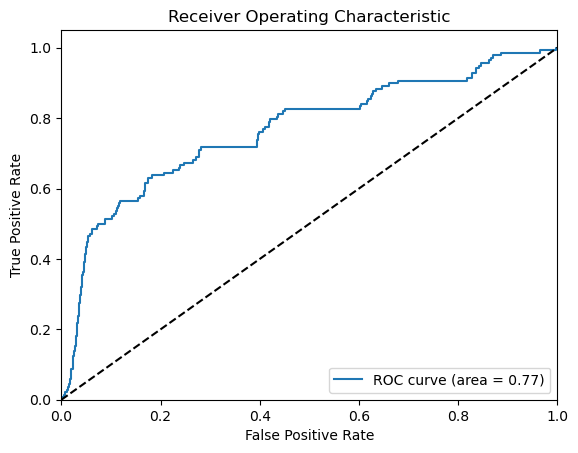

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

# your code here
fpr, tpr, _ = roc_curve(data.y, score)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


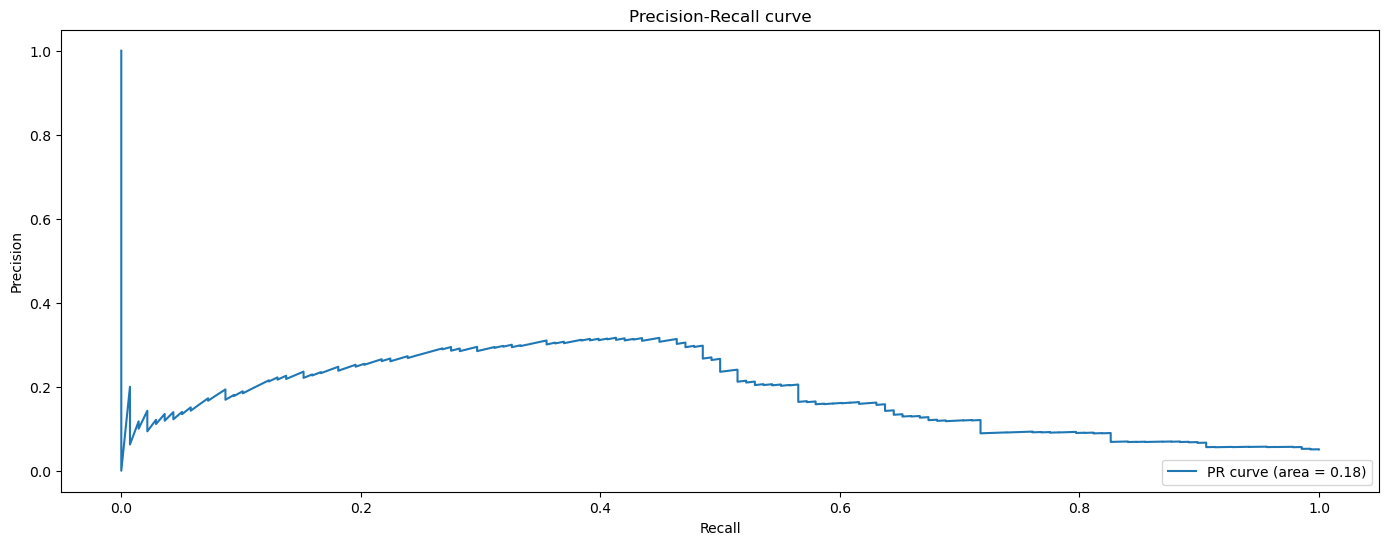

In [ ]:

# evaluamos el rendimiento del detector con una gráfica PR de sklearn


precision, recall, _ = precision_recall_curve(data.y, score)
average_precision = average_precision_score(data.y, score)

figsize = (17, 6)
plt.figure(figsize=figsize)
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()




In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que 'data.y' son las etiquetas verdaderas y 'pred' son las etiquetas predichas
cm = confusion_matrix(data.y, predichos)
print(cm)


[[2368  202]
 [  69   69]]


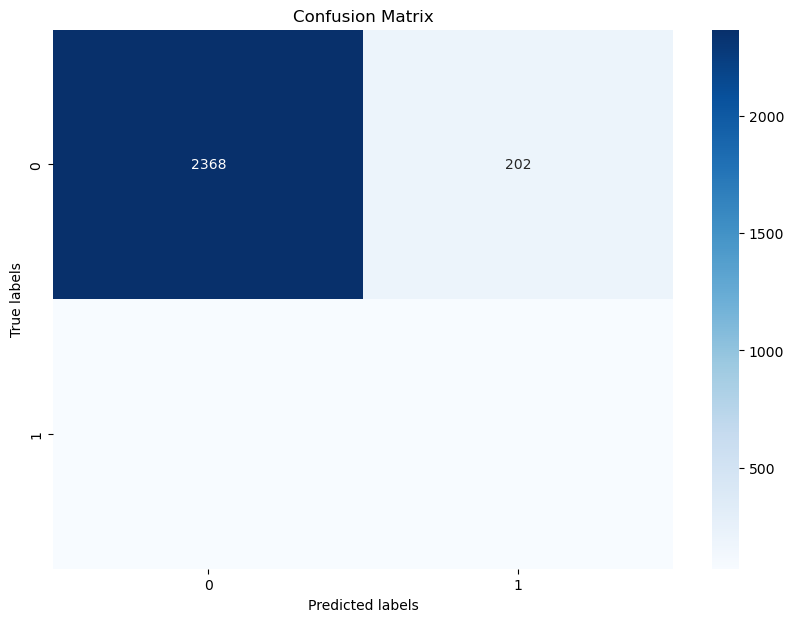